<h1>SIFT</h1>

In [16]:
# import python modules
import cv2
import numpy as np
from skimage import data
from skimage import transform
import scipy
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT
from scipy.signal import convolve2d
from scipy import ndimage
import matplotlib.pyplot as plt

In [17]:
image = data.astronaut()
image = rgb2gray(image)

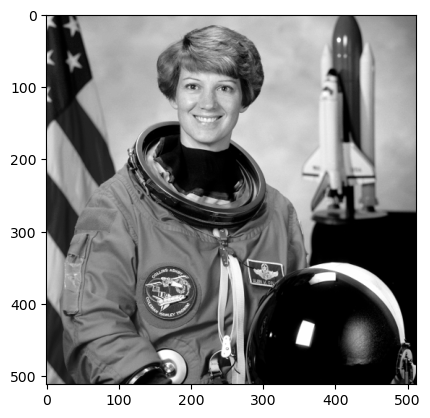

In [18]:
plt.imshow(image)
plt.show()

building a scale space

In [22]:
def make_scale_space_direct(f, s_0, s_max, n_scales):
    alpha = (s_max / s_0)**(1 / (n_scales - 1))
    scales = s_0 * alpha**np.arange(n_scales)
    diff_scales_from_s0 = np.sqrt(scales[1:]**2 - s_0**2)

    fs = np.empty((n_scales, *f.shape))
    fs[0] = f.copy()

    for i, s in enumerate(diff_scales_from_s0):
        fs[i + 1] = gaussian_filter(f, s)

    return fs, scales


def make_scale_space_incremental(f, s_0, s_max, n_scales):
    alpha = (s_max / s_0)**(1 / (n_scales - 1))
    scales = s_0 * alpha**np.arange(n_scales)
    diff_scales_from_si = np.sqrt(scales[1:]**2 - scales[:-1]**2)

    fs = np.empty((n_scales, *f.shape))
    fs[0] = f.copy()

    for i, s in enumerate(diff_scales_from_si):
        fs[i + 1] = gaussian_filter(fs[i], s)

    return fs, scales


def make_scale_space_octaves(f, O, k, s0):
    n = O * k
    alpha = 2 ** (1 / k)
    scales = s0 * alpha ** np.arange(n)
    conv_scales_from_s0 = s0 * np.sqrt(alpha ** (2 * np.arange(n)) - 1)

    fs = np.empty((n, *f.shape))
    fs[0] = f.copy()

    for i, s in enumerate(conv_scales_from_s0[1:]):
        fs[i + 1] = gaussian_filter(f, s)

    return fs, scales




Build scale space and DoG with test image for 

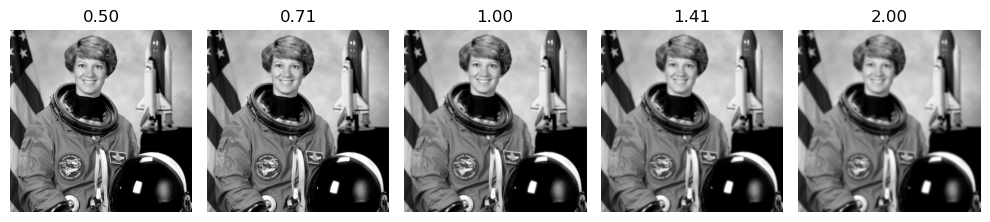

In [23]:
f = image

g = f / 255

n_scales = 5
s0 = 0.5
s_max = 2
fs_direct, scales = make_scale_space_direct(g, s0, s_max, n_scales)

fig_scsp_direct, axs = plt.subplots(1, n_scales, figsize=(2*n_scales, 2.4))
n = n_scales

for i, s in enumerate(scales):
    axs[i].imshow(fs_direct[i], cmap=plt.cm.gray)
    axs[i].axis('off')
    axs[i].set_title(f"{s:2.2f}")

    plt.tight_layout()

plt.savefig('octave1')


plt.show()

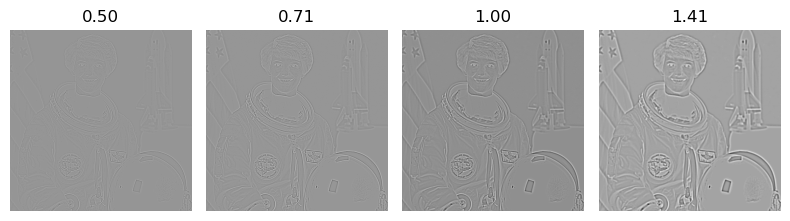

In [24]:
diff = fs = np.empty((n_scales-1, *f.shape))
for i in range(4):
    diff[i] = fs_direct[i+1] - fs_direct[i]

scales = scales[:-1]
fig_scsp_direct, axs = plt.subplots(1, n_scales -1, figsize=(2*(n_scales-1), 2.4))
n = n_scales - 1

for i, s in enumerate(scales):
    axs[i].imshow(diff[i], cmap=plt.cm.gray)
    axs[i].axis('off')
    axs[i].set_title(f"{s:2.2f}")

    plt.tight_layout()

plt.savefig('dog1')
plt.show()

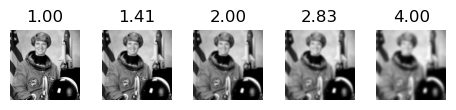

In [25]:
g = g[::2, ::2]

n_scales = 5
s0 = 1
s_max = 4
fs_direct, scales = make_scale_space_direct(g, s0, s_max, n_scales)

fig_scsp_direct, axs = plt.subplots(1, n_scales, figsize=(n_scales, 1.2))
n = n_scales

for i, s in enumerate(scales):
    axs[i].imshow(fs_direct[i], cmap=plt.cm.gray)
    axs[i].axis('off')
    axs[i].set_title(f"{s:2.2f}")

    plt.tight_layout()

plt.savefig('octave2')
plt.show()

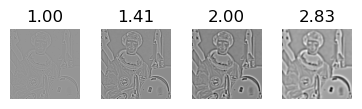

In [26]:
diff = fs = np.empty((n_scales-1, *g.shape))
for i in range(4):
    diff[i] = fs_direct[i+1] - fs_direct[i]

scales = scales[:-1]
fig_scsp_direct, axs = plt.subplots(1, n_scales-1, figsize=((n_scales-1), 1.2))
n = n_scales - 1

for i, s in enumerate(scales):
    axs[i].imshow(diff[i], cmap=plt.cm.gray)
    axs[i].axis('off')
    axs[i].set_title(f"{s:2.2f}")

    plt.tight_layout()

plt.savefig('dog2')
plt.show()

Use SIFT on test image.

Example 4.11

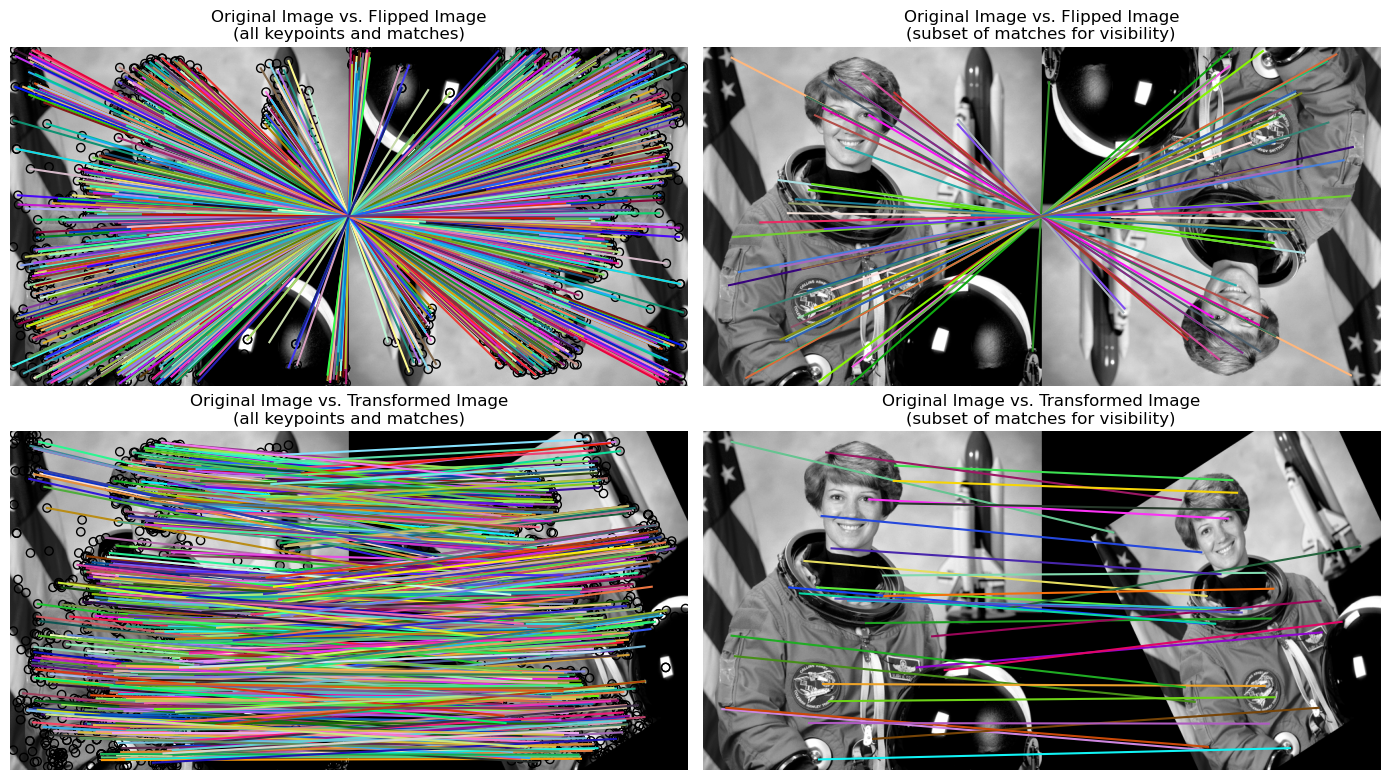

In [27]:
img1 = image
img2 = transform.rotate(img1, 180)
tform = transform.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                                  translation=(0, -200))
img3 = transform.warp(img1, tform)

descriptor_extractor = SIFT()

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img3)
keypoints3 = descriptor_extractor.keypoints
descriptors3 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, max_ratio=0.6,
                              cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, max_ratio=0.6,
                              cross_check=True)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

plt.gray()

plot_matches(ax[0, 0], img1, img2, keypoints1, keypoints2, matches12)
ax[0, 0].axis('off')
ax[0, 0].set_title("Original Image vs. Flipped Image\n"
                   "(all keypoints and matches)")

plot_matches(ax[1, 0], img1, img3, keypoints1, keypoints3, matches13)
ax[1, 0].axis('off')
ax[1, 0].set_title("Original Image vs. Transformed Image\n"
                   "(all keypoints and matches)")

plot_matches(ax[0, 1], img1, img2, keypoints1, keypoints2, matches12[::20],
             only_matches=True)
ax[0, 1].axis('off')
ax[0, 1].set_title("Original Image vs. Flipped Image\n"
                   "(subset of matches for visibility)")

plot_matches(ax[1, 1], img1, img3, keypoints1, keypoints3, matches13[::20],
             only_matches=True)
ax[1, 1].axis('off')
ax[1, 1].set_title("Original Image vs. Transformed Image\n"
                   "(subset of matches for visibility)")

plt.tight_layout()
plt.savefig('sift')
plt.show()